# Set up

In [1]:
img_folder = 'random_prompts/'

prompts = ["A woman holding a bouquet of flowers and a puppy in a park",
           "A group of friends having a picnic in the countryside",
           "A couple dancing at a wedding reception",
           "A family walking on a beach during sunset",
           "A person practicing yoga in a peaceful garden",
           "A child blowing out birthday candles on a cake",
           "A group of people enjoying a concert in a stadium",
           "A man proposing to his girlfriend on a mountain top",
           "A mother and daughter baking cookies in the kitchen", 
           "A businessman shaking hands with a client in an office",
           "A family having a barbecue in their backyard",
           "A group of coworkers celebrating a successful project",
           "A person taking a selfie with a famous landmark", 
           "A mother and son playing in a park", 
           "A woman getting a haircut at a salon",
           "A group of friends playing volleyball on the beach",
           "A man riding a bike through a city park",
           "A woman enjoying a book and a cup of tea in a cozy living room",
           "A woman walking her dog on a beach at sunset",    
           "A group of friends hiking in a forest with a waterfall in the background", 
           "A person skateboarding in a city park with skyscrapers in the background",  
           "A group of people kayaking down a river surrounded by mountains",   
           "A couple walking hand in hand through a winter wonderland",    
           "A person reading a book on a hammock in a tropical garden",   
           "A group of friends having a barbecue on a rooftop terrace",   
           "A couple riding bicycles on a scenic country road",   
           "A person practicing yoga on a beach at sunrise",  
           "A group of people enjoying a boat ride on a calm lake",
          "A nurse administering medication to a patient",
          "A chef preparing a meal in a restaurant kitchen",
          "A parent reading a bedtime story to their child",
          "A scientist observing a chemical reaction in a lab",
          "A therapist counseling a client in their office",
          "A teacher instructing a class of students",
          "A coach training an athlete at the gym",
          "A firefighter rescuing a person from a burning building",
          "A musician performing on stage for a live audience",
          "A police officer patrolling a neighborhood",
          "A surgeon performing a delicate operation",
          "A construction worker laying bricks on a building site",
          "A flight attendant assisting passengers on a plane",
          "A veterinarian examining a sick animal",
          "A soldier serving in a war zone",
          "A salesperson closing a deal with a customer",
          "A journalist conducting an interview with a celebrity",
          "A therapist leading a group therapy session",
            "A bride and groom sharing a first dance at their wedding",    
           "A group of athletes competing in a high-intensity sports game",  
           "A family gathered around a cozy fireplace on a winter evening",  
           "A surfer catching a wave at a tropical beach",  
           "A group of friends enjoying a night out on the town", 
           "A fashion model posing for a photo shoot on a city street",
           "A mother and child playing in a park on a sunny day",  
           "A traveler exploring a new city and experiencing its culture",  
           "A firefighter battling a raging inferno in a burning building", 
           "A teacher inspiring and educating a classroom of students",  
           "A couple strolling hand-in-hand through a blooming garden",  
           "A group of musicians jamming together in a garage band",   
           "A dancer performing a passionate and expressive routine",   
           "A scientist researching and discovering new breakthroughs",   
           "A parent reading a bedtime story to their child",  
           "A cyclist racing in a high-speed bike competition",  
           "A group of friends laughing and having fun at a party", 
           "A chef presenting a beautiful and delicious dish at a restaurant",  
           "A soldier bravely serving their country in a warzone",  
           "A couple enjoying a sunset on a secluded beach",    
           "A businessperson closing a major deal in a boardroom", 
           "A group of volunteers helping and serving their community", 
           "A doctor comforting and treating a sick patient in a hospital", 
           "A fashion designer sketching out their latest designs", 
           "A dancer practicing in a dimly lit studio",  
           "A group of tourists taking in the sights and sounds of a new city",   
           "A student studying and preparing for a big exam",  
           "A cyclist enjoying a leisurely ride through a scenic countryside",  
           "A group of friends enjoying a game night at home",  
           "A scientist examining a microscope slide in a lab",   
           "A couple enjoying a hot air balloon ride over a picturesque landscape",  
           "A businessperson giving a powerful and inspiring presentation",   
           "A mother comforting her child after a bad dream",  
           "A surfer catching a sunset wave in the ocean",   
           "A firefighter rescuing a person from a burning building",    
           "A teacher guiding and mentoring a student one-on-one",   
           "A group of athletes practicing and training together"]

prompts_length = len(prompts)

# Dependencies

In [2]:
#!pip install diffusers
#!pip install transformers scipy ftfy accelerate
#!pip install git+https://github.com/openai/CLIP.git --run at least once!

#Imports
import torch
from torch import nn
import numpy as np
import platform
import clip
import cv2
from PIL import ImageChops, Image
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import random
import sys
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import re
import time
from os.path import exists
from os import mkdir
import argparse


from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Canny Model

In [3]:
def encode_image(image_path): #encode a single image to 512 vector
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model, preprocess = clip.load('ViT-B/32', device=device)
    
    # Load the image and preprocess it
    image = Image.open(image_path)
    image = image.resize((224, 224))
    image = preprocess(image).unsqueeze(0)
    
    with torch.no_grad():
        image_features = model.encode_image(image)
    image_features = image_features[0] # flatten the feature tensor
    return image_features 

def encode_images(image_paths): #encode multiple images to 512 vectors
    #encode images to 512 vectors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model, preprocess = clip.load('ViT-B/32', device=device)
    
    # Load the images and preprocess them
    images = []
    for image_path in image_paths:
        image = Image.open(image_path)
        image = image.resize((224, 224))
        image = preprocess(image)
        images.append(image)
    images = torch.stack(images)
    
    with torch.no_grad():
        image_features = model.encode_image(images)
    image_features = image_features.view(image_features.shape[0], -1) # flatten the feature tensor
    return image_features

def MLP(input_dim, output_dim, hidden_layers_dims, activation, bias):
    """This function creates a multi-layer perceptron.

    Args:
        input_dim (int): The input dimension of the MLP.
        output_dim (int): The output dimension of the MLP.
        hidden_layers_dims (list): A list of integers that represent the number of hidden layers and their dimensions.
        activation (nn.functional, optional): The activation function to use. Defaults to tanh.

    Returns:
        nn.Module: The MLP
    """
    layers = []
    layers.append(nn.Linear(input_dim, hidden_layers_dims[0], bias=bias))
    layers.append(activation)
    for i in range(1, len(hidden_layers_dims)):
        layers.append(nn.Linear(hidden_layers_dims[i - 1], hidden_layers_dims[i], bias=bias))
        layers.append(activation)
    layers.append(nn.Linear(hidden_layers_dims[-1], output_dim, bias=bias))

    return nn.Sequential(*layers)

class CannyModel(nn.Module):
    
    def __init__(self, input_dim=512, output_dim=4, hidden_layers_dims=[16,16], activation=nn.ReLU()):
        #NOTE: input_dims shall correspond to dimension output of the image encoder (here 512 fits the output of the clip image encoder used above)
        # output_dim shall corresponds to the number of parameters at the output we want: 4 canny parameters
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        super().__init__()

        # Define a neural MLP network by specifying number of inputs neurons output neurons 
        # and number neurons in intermediate layers (hidden layer)
        self.model=MLP(input_dim, output_dim, hidden_layers_dims, activation, bias=True)
        self.model.to(device)

    def forward_1img(self, image): #forward pass for one image
        image_feature_vector=encode_image(image) #image to feature vector by passing through pretrained model
        canny_parameters=self.model(image_feature_vector)#image feature vector to canny parameters by passing through model
        return canny_parameters 
    
    def forward(self, images):   #forward pass for multiple images    
        image_feature_vectors = encode_images(images) #images to feature vectors by passing through pretrained model
        canny_parameters = self.model(image_feature_vectors) #feature vectors to canny parameters by passing through model
        return canny_parameters
   
    def get_weights(self): #get weights of model
        param = nn.utils.parameters_to_vector(
            self.parameters()).detach().numpy()
        return param

# Segmentation + Canny

In [4]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

def segment(image):

    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(dim=1).squeeze().detach().cpu().numpy()

    # Define the masks
    person_mask = (predictions == 12).astype(np.uint8)
    other_mask = (predictions != 12).astype(np.uint8)

    # Resize the masks to match the original image size
    person_mask = np.array(Image.fromarray(person_mask).resize(image.size, resample=Image.NEAREST))
    other_mask = np.array(Image.fromarray(other_mask).resize(image.size, resample=Image.NEAREST))

    # Apply the masks to the original image and save the results
    person_image = np.array(image) * person_mask[..., np.newaxis]
    other_image = np.array(image) * other_mask[..., np.newaxis]

    person_image_rgb = person_image[...,::-1] * person_mask[..., np.newaxis]
    other_image_rgb = other_image[...,::-1] * other_mask[..., np.newaxis]

    person_image_rgba = np.concatenate([person_image_rgb, person_mask[..., np.newaxis] * 255], axis=-1)
    other_image_rgba = np.concatenate([other_image_rgb, other_mask[..., np.newaxis] * 255], axis=-1)

    return Image.fromarray(other_image_rgba.astype(np.uint8)),Image.fromarray(person_image_rgba.astype(np.uint8))


def canny_edge(low_human,high_human,low_other,high_other,other_image,human_image=None):
    other_image.save("other.png")
    
    #Edge detection of others
    img = cv2.imread("other.png") 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.Canny(img, low_other,high_other)
    img = 255 - img 
    cv2.imwrite("image_other_edge.png",img)

    if (human_image != None): 
        #Edge detection of human
        human_image.save("human.png")
        img = cv2.imread("human.png")  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.GaussianBlur(img, (3, 3), 0)
        img = cv2.Canny(img, low_human,high_human)
        img = 255 - img
        cv2.imwrite("image_human_edge.png",img)
        
        #Blending of images
        blended = Image.open("image_other_edge.png")
        human_img = Image.open("image_human_edge.png")
        blended = ImageChops.darker(blended,human_img)
    else: 
        blended = Image.open("image_other_edge.png")
    return blended



c:\Users\maja_\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
c:\Users\maja_\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


# Fitness function


In [5]:
def split_long(s): #splits long prompts so that they are shown nicely by the image
    pattern = r'.{1,20}(?=\s|$)'
    s = re.sub(pattern, r'\g<0>\n', s)
    return s
  
def shift_params(canny_params): #shifts the parameters so that they are in the range closer to the parameters we want
    shifted_x = canny_params - torch.min(canny_params.abs())
    shifted_x = torch.abs(shifted_x)
    shifted_x[1] = shifted_x[0]+shifted_x[1] #making sure high is higher than low
    shifted_x[3] = shifted_x[2]+shifted_x[3] #making sure high is higher than low
    return shifted_x*12
    
def get_prompts(): #get three random prompts 
    rand = random.sample(range(1, prompts_length-1), 5)
    for i in range(5):
        rand[i] = prompts[rand[i]]
    return rand

def add_img_end(list):
    list_ = []
    for i in list:
        list_.append(img_folder+i+"_50.png")
    return list_

def get_image(prompt): #get image from prompt
    return Image.open(img_folder+prompt+"_50.png")   

In [10]:
 

def fitness_batch(evolved_parameters: np.array, args=None) -> float:
    """
    For an interactive evolution, with N(=num_candidates) structures compared.
    Ask the human to select a structure among N structures generated each by a different policy network (MLP).
    input:
        evolved_parameters: np.array of size num_candidates * N_policy_param(>>), gathering the parameters of the num_candidates policy network compared here.
        args: dictionary of parameters given as input of train
        model: Image model..
    output:
        rewards: list of size num_candidates of rewards for each of these networks.

    """
    
    #number of time will ask human rate the structures per generation: depends population size and num_candidates
    num_rounds=math.floor(args.population_size/args.num_candidates)
    rewards = [0]*args.population_size
    num_prompts=5
    images_show=[] #contain images all candidates                         

    # Loop on the whole structure
    print("About to Evaluate {} elements in {} rounds with {} prompts".format(args.population_size, num_rounds, num_prompts))
    for j in range(0,num_rounds):
        prompts_for_round = get_prompts()
        images=[] #contain images all candidates                         
        img_to_canny = [] #contain original images to be canny edge detected
        other_seg = [] #list of segmented parts of other
        human_seg = [] #list of segmented part of humans

         #---1---Create Image for all candidates and all prompts 
        for k in range(0,args.num_candidates):   
            
            #find param_candidate in evolved_parameters for each candidate
            idx_candidate_in_pop= j*args.num_candidates+k
            nn_candidate=evolved_parameters[idx_candidate_in_pop]   
            parameters_candidate = nn_candidate(add_img_end(prompts_for_round))
            canny_params = parameters_candidate[j]
            canny_params = shift_params(canny_params)
            images_=[]
            for i in range(0,num_prompts):  
                if(k==0):
                    image = get_image(prompts_for_round[i])               
                    img_to_canny.append(image)
                    other_img,human_img = segment(image)
                    other_seg.append(other_img)
                    human_seg.append(human_img)                  
                    image=canny_edge(canny_params[0].item(),canny_params[1].item(),canny_params[2].item(),canny_params[3].item(),other_img,human_img) #canny edge detect image
                else: 
                    image = canny_edge(canny_params[0].item(),canny_params[1].item(),canny_params[2].item(),canny_params[3].item(),other_seg[i],human_seg[i]) #canny edge detect image
                
                plt.imshow(image)
                plt.axis('off')
                plt.show()
                if(args.clear_output):
                    clear_output(wait=True)

                images_.append(image)
            images.append(images_)
        images_show.append(images)
          
    for j in range(0,num_rounds):
        print(images_show[j])
        #---2--- Display these images and ask human to rank these candidates
        fig,axes = plt.subplots(nrows=num_prompts, ncols=args.num_candidates, figsize=(10, 10))
        for ii in range(0, args.num_candidates):
            for jj in range(0, num_prompts):
                axes[jj,ii].imshow(images_show[j][ii][jj],cmap="gray")#ith candidate and jth prompt
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        columnLabels = ['Candidate {}'.format(col) for col in range(1, args.num_candidates+1)]
        rowLabels = prompts_for_round 
        for ax, label in zip(axes[0], columnLabels):
            ax.set_title(label,fontsize=10)
        for ax, label in zip(axes[:,0], rowLabels):
            ax.set_ylabel(label,rotation=0,fontsize=6)
            ax.yaxis.set_label_coords(-0.3, 0.5)
        
        fig.tight_layout()
        plt.show() 
            
        # Ask Rating Human
        print(f"Round {j} Choose the best of these images, from 1 to {args.num_candidates}\n")

        while True: #in case entry not valid
            try:
                index = int(input()) #this is the ranking of the human
                if index not in np.arange(args.num_candidates)+1:
                    print('Entry not valid, try again. Press 0 to EXIT. Entry should be in {}'.format(np.arange(args.num_candidates))+1)
                else:
                    break
            except:
                print('Entry not valid, try again. Press 0 to EXIT. Entry should be in {}'.format(np.arange(args.num_candidates)+1))
            if index == 0:
                print("Finishing Evolution early")
                sys.exit("Bye")
        print(f"Round {j} Human has selected entry {index}\n")
        #---3--- Update Reward
        plt.close()
        # Gives reward to selected candidate
        idx_selected_candidate_in_pop = j*args.num_candidates+index-1
        print("Good Candidate element {} / {}".format(idx_selected_candidate_in_pop+1, args.population_size))
        rewards[idx_selected_candidate_in_pop] = 1
        if(args.clear_output):
            clear_output(wait=True)
    return rewards  

# Evolutionary strategy

In [7]:
class EvolutionStrategyStatic(object):
    def __init__(self, args): 
        self.args = args
        self.get_reward = fitness_batch
        if (args.new_run == None):
            self.generation = 0
            self.population_size = args.population_size
            self.sigma = args.sigma
            self.lr = args.lr
            self.lr_decay = args.lr_decay
            self.batch_size=args.num_candidates
            self.used_population = []
            self.sigma_decay = args.sigma_decay
            self.weights = self.init_weights()
            self.id_ = str(int(time.time()))
        else:
            dict = torch.load("weights/"+args.new_run)
            self.generation = dict["generation"]+1
            self.sigma = dict["sigma"]
            self.population_size = dict["population_size"]
            self.lr = dict["lr"]
            self.lr_decay = dict["lr_decay"]
            self.batch_size = dict["batch_size"]
            self.used_population = dict["used_population"]
            self.sigma_decay = dict["sigma_decay"]
            self.weights = dict["weights"]
            self.id_ = dict["id_"]
        
    def to_dict(self):
        return {key: value for key, value in self.__dict__.items() if not key.startswith('__') and not callable(key)}

    def init_weights(self): #get initial weights, which is set randomly
        canny=CannyModel()
        weight_dim=512*16+16*16+16*4
        bias_dim=16+16+4
        evolved_parameters=(2*np.random.rand((weight_dim+bias_dim))-1)
        nn.utils.vector_to_parameters(torch.tensor(evolved_parameters, dtype=torch.float32),  canny.parameters())
        return canny 
    
    def get_NN(self, w, p): # get nerual network based on weights and noise vector 
        #p is np array noise vector for one element in the population
        #w is the mean weight vector
        canny=CannyModel()
        evolved_parameters=w.get_weights()+self.sigma*p
        nn.utils.vector_to_parameters(torch.tensor(evolved_parameters, dtype=torch.float32),  canny.parameters())
        return canny 

    def get_noise_vector(self): #make a random vector of size of neural network weights
        population = []
        for _ in range(self.population_size):
            weight_dim=512*16+16*16+16*4
            bias_dim=16+16+4
            evolved_parameters=(2*np.random.rand((weight_dim+bias_dim))-1) 
            population.append(evolved_parameters)  
        return population  
    
    def evaluate(self, noise_vector): #create population and give rewards
        rewards = []
        population = [self.get_NN(self.weights, p) for p in noise_vector] #generate population
        rewards = self.get_reward(population, self.args) #run fitness function to get rewards
        rewards = np.array(rewards)
        self.used_population = population
        return rewards

    def update_weights(self, rewards, noise_vector): #update weights based on rewards 
        weight_parameters = self.weights.get_weights() 
        
        for index, w in enumerate(weight_parameters): 
            layer_noise_vector = np.array([p[index] for p in noise_vector])   # Array of all weights[i] for all the networks in the population
            self.update_factor = self.lr / (self.population_size * self.sigma)
            weight_parameters[index] = w + self.update_factor * np.dot(layer_noise_vector.T, rewards).T #for each element in the weight vector, update it based on the rewards of the population
       
        nn.utils.vector_to_parameters(torch.tensor(weight_parameters, dtype=torch.float32),  self.weights.parameters()) #update weights parameters
        
        if self.update_factor > 0.001: #decay learning rate
            self.lr *= self.lr_decay

        if self.sigma>0.001: #decay sigma
            self.sigma *= self.sigma_decay


    def run(self, generations, path='outputs'):
        if not exists(path + '/' + self.id_):
            mkdir(path + '/' + self.id_)

        if self.generation == 0: 
            with open(path +"/" + self.id_ + "/"+ "args.txt", 'w') as output:
                args_dict = vars(self.args)
                for key in args_dict:
                    output.write(key + " : " + str(args_dict[key])+"\n")
            
            torch.save(self.weights, path +"/" + self.id_ + "/"+"weights_gen_{:02d}__".format(self.generation)+   "sigma_" + str(self.sigma)[:4] + "__lr_" + str(self.lr)[:6] + ".pt")
            torch.save(self.used_population, path + "/"+ self.id_ + "/" +"used_population_gen_{:02d}__".format(self.generation)+ "sigma_" + str(self.sigma)[:4] + "__lr_" + str(self.lr)[:6] + ".pt")  
            torch.save(self.to_dict(),path +"/" + self.id_ + "/"+"state_gen_{:02d}.pt".format(self.generation))

            
        print('\n********************\n \n Evolutionary RUN: ' + self.id_ + '\n\n********************\n')
        # Algorithm 2. Salimans, 2017: https://arxiv.org/abs/1703.03864
        
        
        while self.generation < generations:                                    
            #1--- get current noise_vector
            noise_vector = self.get_noise_vector()         
                               
            #2-- evaluate reward
            rewards = self.evaluate(noise_vector)
                     
            #3--mutate parameters for next generation
            self.update_weights(rewards, noise_vector)
            
            self.generation += 1
            #save weights, population, and args
            print('iter %4i | update_factor: %f  lr: %f  sigma: %f |' % (self.generation + 1, self.update_factor, self.lr, self.sigma), flush=True)
            torch.save(self.weights, path +"/" + self.id_ + "/"+"weights_gen_{:02d}__".format(self.generation)+   "sigma_" + str(self.sigma)[:4] + "__lr_" + str(self.lr)[:6] + ".pt")
            torch.save(self.used_population, path + "/"+ self.id_ + "/" +"used_population_gen_{:02d}__".format(self.generation)+ "sigma_" + str(self.sigma)[:4] + "__lr_" + str(self.lr)[:6] + ".pt")  
            torch.save(self.to_dict(),path +"/" + self.id_ + "/"+"state_gen_{:02d}.pt".format(self.generation))


# Train

In [8]:
def main(args):
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_candidates', type=int, default=2, 
                        help='Number of candidates elements among which to choose one.')
    parser.add_argument('--lr', type=float,  default=0.1, 
                        help='ES learning rate.')
    parser.add_argument('--lr_decay', type=float,  default=0.99, #reduce if want to converge faster
                        help='ES and learning rate decay.') 
    parser.add_argument('--sigma', type=float,  default=0.4,
                        help='ES sigma: modulates the amount of noise used to populate each new generation, the higher the more the entities will vary')
    parser.add_argument('--sigma_decay', type=float,  default=0.95, 
                        help='Simga rate decay.') 
    parser.add_argument('--generations', type=int, default=4, 
                        help='Number of generations that the ES will run.')
    parser.add_argument('--population_size', type=int, default=4,
                        help='Size of population (needs to be pair and be a multiple of choice_batch or will be approximated).')
    parser.add_argument('--new_run', type=str, default=None,
                        help='If continue from a previous run, specify the path to the folder containing the run. e.g. 178../state_gen_00.pt')
    parser.add_argument('--clear_output', type=bool, default=True, 
                        help='If want to clear output while running true else false')

    #---Parameters to save the folder ----
    parser.add_argument('--folder', type=str, default='weights',
                        metavar='', help='folder to store the evolved weights')
    
    args = parser.parse_args(args)
    print(args)

    assert args.num_candidates <= args.population_size

    if not exists(args.folder): 
        mkdir(args.folder) 
        
    # Initialise the EvolutionStrategy class
    print('\nInitialising Evolution Strategies')
    es = EvolutionStrategyStatic( args=args)

    # Start the evolution
    print('\nRunning ES for {} generations, solutions saved at {}'.format(args.generations, args.folder))
    es.run(args.generations, path=args.folder)

# Run

[[<PIL.Image.Image image mode=L size=512x512 at 0x22E3D6FFE50>, <PIL.Image.Image image mode=L size=512x512 at 0x22E3F54E1D0>, <PIL.Image.Image image mode=L size=512x512 at 0x22E3EBAD930>, <PIL.Image.Image image mode=L size=512x512 at 0x22E3ED934F0>, <PIL.Image.Image image mode=L size=512x512 at 0x22E3ED90430>], [<PIL.Image.Image image mode=L size=512x512 at 0x22E3EDCF310>, <PIL.Image.Image image mode=L size=512x512 at 0x22E3EBAE7A0>, <PIL.Image.Image image mode=L size=512x512 at 0x22E3ED4D420>, <PIL.Image.Image image mode=L size=512x512 at 0x22E3EE118D0>, <PIL.Image.Image image mode=L size=512x512 at 0x22E3EBAD450>]]


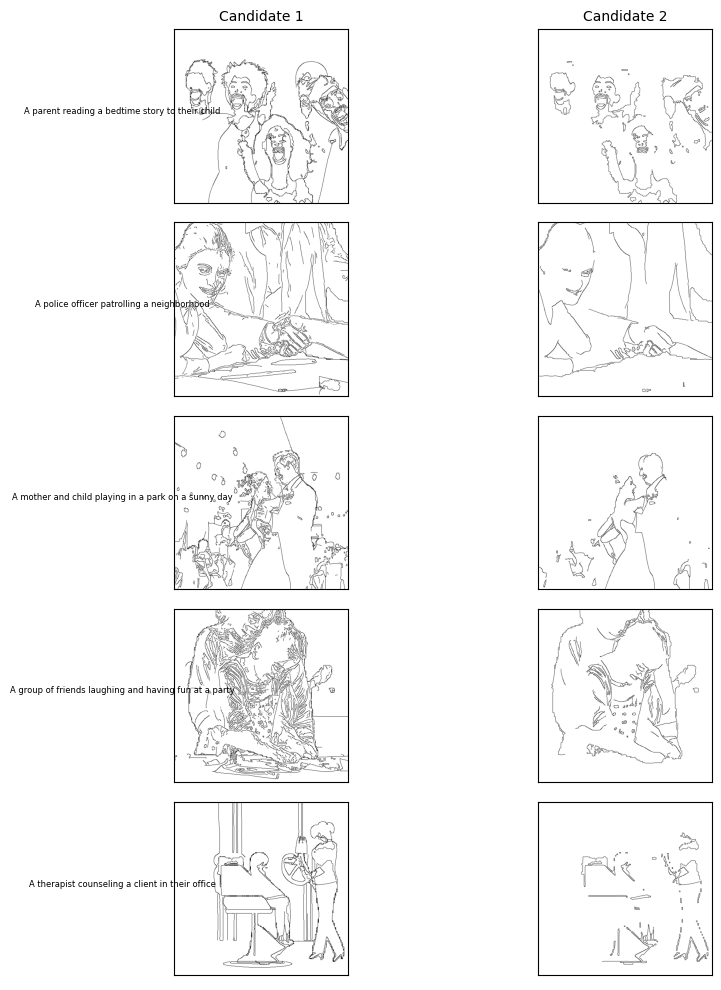

Round 0 Choose the best of these images, from 1 to 2

Entry not valid, try again. Press 0 to EXIT. Entry should be in [1 2]
Finishing Evolution early


SystemExit: Bye

C:\Users\maja_\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [11]:
if __name__ == '__main__':
    # Replace the list below with the command-line arguments you want to use
    args = ["--num_candidates","2","--generations","100","--population_size","4","--lr_decay", "0.95","--lr","1","--sigma","0.6","--sigma_decay","0.96","--clear_output","False"]
    main(args)